In [28]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
!gdown --id 18EKtq0UGA6OvnzUu87RAOAxCul-tE0rN

Downloading...
From: https://drive.google.com/uc?id=18EKtq0UGA6OvnzUu87RAOAxCul-tE0rN
To: /content/PCOFFOTMUSDM.csv
100% 9.94k/9.94k [00:00<00:00, 25.5MB/s]


In [30]:
coffee_df = pd.read_csv('PCOFFOTMUSDM.csv')
coffee_df.head()

,DATE,PCOFFOTMUSDM
0,1990-01-01,75.829987
1,1990-02-01,84.010010
2,1990-03-01,93.959991
3,1990-04-01,93.730011
4,1990-05-01,92.019989


Text(0, 0.5, 'Price in USD cents per pound')

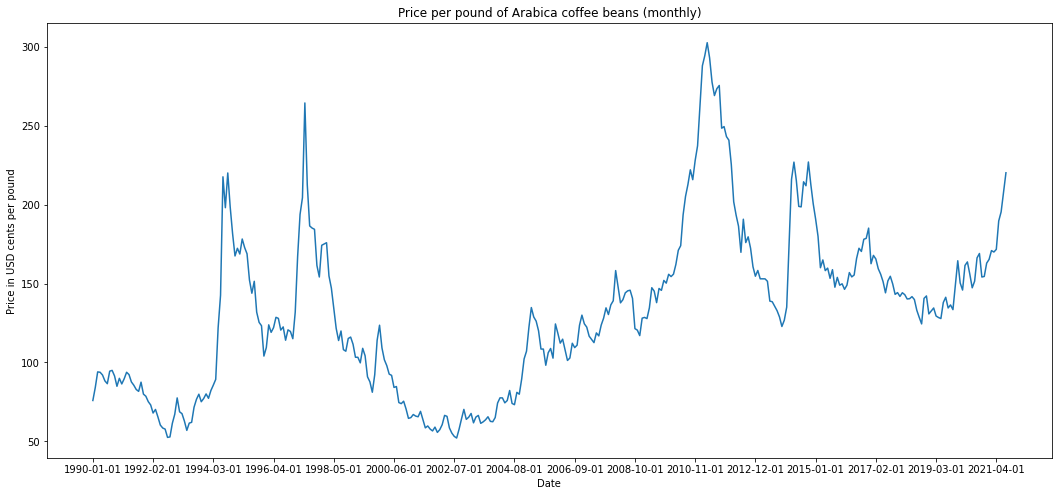

In [31]:
prices = np.array(coffee_df.PCOFFOTMUSDM)
dates = np.array(coffee_df.DATE)

fig, ax = plt.subplots(figsize=(18, 8))
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.plot(dates,prices)
ax.title.set_text("Price per pound of Arabica coffee beans (monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Price in USD cents per pound")

In [32]:
test_size = 20

dates_train = dates[:-test_size]
prices_train = prices[:-test_size]
dates_valid = dates[-test_size:]
prices_valid = prices[-test_size:]

In [33]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Standard Multi-Layer Perceptron Model

In [ ]:
window_size = 64
batch_size = 128
tf.keras.backend.clear_session()

train_set = tf.data.Dataset.from_tensor_slices(prices_train)
train_set = train_set.window(window_size + 1, shift=1, drop_remainder=True)
train_set = train_set.flat_map(lambda window: window.batch(window_size + 1))
train_set = train_set.shuffle(len(prices_train)).map(lambda window: (window[:-1], window[-1]))
train_set = train_set.batch(batch_size).prefetch(1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9),
              metrics=["mae"])

history = model.fit(train_set,epochs=900)

Epoch 1/900
3/3 [==============================] - 0s 10ms/step - loss: 30490.8145 - mae: 160.7006
Epoch 2/900
3/3 [==============================] - 0s 6ms/step - loss: 5475.3862 - mae: 58.2079
Epoch 3/900
3/3 [==============================] - 0s 8ms/step - loss: 8371.1768 - mae: 75.7224
Epoch 4/900
3/3 [==============================] - 0s 7ms/step - loss: 2474.4758 - mae: 38.9117
Epoch 5/900
3/3 [==============================] - 0s 8ms/step - loss: 5000.1089 - mae: 62.1655
Epoch 6/900
3/3 [==============================] - 0s 6ms/step - loss: 1689.7754 - mae: 30.4769
Epoch 7/900
3/3 [==============================] - 0s 9ms/step - loss: 2288.8687 - mae: 37.8488
Epoch 8/900
3/3 [==============================] - 0s 7ms/step - loss: 2254.0273 - mae: 38.1535
Epoch 9/900
3/3 [==============================] - 0s 7ms/step - loss: 1325.0640 - mae: 28.1284
Epoch 10/900
3/3 [==============================] - 0s 10ms/step - loss: 1559.5355 - mae: 28.6938
Epoch 11/900
3/3 [=================

In [ ]:
forecast=[]
for time in range(len(prices) - window_size):
  forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[360-window_size:]
results = np.array(forecast)[:, 0, 0]

fig, ax = plt.subplots(figsize=(18, 8))
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.plot(dates_valid, prices_valid)
ax.plot(dates_valid, results)
ax.title.set_text("Price per pound of Arabica coffee beans (monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Price in USD cents per pound")
ax.legend(['Actual prices','Forecasted prices'])

In [ ]:
tf.keras.metrics.mean_absolute_error(prices_valid, results).numpy()

# Simple Recurrent Neural Network

In [ ]:
window_size=32;batch_size=64
train_set = tf.expand_dims(prices_train, axis=-1)
train_set = tf.data.Dataset.from_tensor_slices(train_set)
train_set = train_set.window(window_size + 1, shift=1, drop_remainder=True)
train_set = train_set.flat_map(lambda w: w.batch(window_size + 1))
train_set = train_set.shuffle(len(dates_train))
train_set = train_set.map(lambda w: (w[:-1], w[1:]))
train_set = train_set.batch(batch_size).prefetch(1)

tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(32, activation='relu',return_sequences=True),
  tf.keras.layers.SimpleRNN(32, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=900)

In [ ]:
forecast=[]
for time in range(len(prices) - window_size):
  forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[360-window_size:]
results = np.array(forecast)[:, 0, 0]

fig, ax = plt.subplots(figsize=(18, 8))
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.plot(dates_valid, prices_valid)
ax.plot(dates_valid, results)
ax.title.set_text("Price per pound of Arabica coffee beans (monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Price in USD cents per pound")
ax.legend(['Actual prices','Forecasted prices'])

In [ ]:
tf.keras.metrics.mean_absolute_error(prices_valid, results).numpy().mean()

## Bidirectional LSTM combined with a Convolutional Neural Network

In [ ]:
window_size = 30 
batch_size = 32

train_set = tf.expand_dims(prices_train, axis=-1)
train_set = tf.data.Dataset.from_tensor_slices(train_set)
train_set = train_set.window(window_size + 1, shift=1, drop_remainder=True)
train_set = train_set.flat_map(lambda w: w.batch(window_size + 1))
train_set = train_set.shuffle(len(dates_train))
train_set = train_set.map(lambda w: (w[:-1], w[1:]))
train_set = train_set.batch(batch_size).prefetch(1)

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(24, activation="relu"),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=900)

In [ ]:
rnn_forecast = model_forecast(model, prices[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[-20:, -1, 0]

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.plot(dates_valid,prices_valid)
ax.plot(dates_valid, rnn_forecast)
ax.title.set_text("Price per pound of Arabica coffee beans (monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Price in USD cents per pound")
ax.legend(['Actual prices','Forecasted prices'])

In [ ]:
tf.keras.metrics.mean_absolute_error(prices_valid, rnn_forecast).numpy()

In [ ]:
df = pd.DataFrame({'Dates':dates_valid, 'Forecasted values':rnn_forecast, 'Actual values':prices_valid})
print(df)

# Hyperparameter Tuning using HParams to determine kernel size and num_conv and num_lstm units

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
from tensorboard.plugins.hparams import api as hp
HP_CONV_UNITS = hp.HParam('conv_units', hp.Discrete([16, 24, 32]))
HP_KERNEL_SIZE = hp.HParam('kernels', hp.Discrete([3,5,7]))
HP_LSTM_UNITS = hp.HParam('lstm_units', hp.Discrete([16, 24, 32, 64]))

METRIC_ACCURACY = "MeanAbsoluteError"

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_CONV_UNITS, HP_KERNEL_SIZE, HP_LSTM_UNITS, HP_MLP_UNITS],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='MAE')]
  )

In [ ]:
def train_test_model(hparams):
  train_set = tf.expand_dims(prices_train, axis=-1)
  train_set = tf.data.Dataset.from_tensor_slices(train_set)
  train_set = train_set.window(window_size + 1, shift=1, drop_remainder=True)
  train_set = train_set.flat_map(lambda w: w.batch(window_size + 1))
  train_set = train_set.shuffle(len(dates_train))
  train_set = train_set.map(lambda w: (w[:-1], w[1:]))
  train_set = train_set.batch(batch_size).prefetch(1)

  model = tf.keras.models.Sequential([
                                      
  tf.keras.layers.Conv1D(filters=hparams[HP_CONV_UNITS], kernel_size=hparams[HP_KERNEL_SIZE],
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hparams[HP_LSTM_UNITS], return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hparams[HP_LSTM_UNITS], return_sequences=True)),
  tf.keras.layers.Dense(hparams[HP_LSTM_UNITS], activation="relu"),
  tf.keras.layers.Dense(hparams[HP_LSTM_UNITS], activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])
    
  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
      loss='huber',
      metrics=["mae"],
  )

  model.fit(train_set, epochs=100) 

  ds = tf.data.Dataset.from_tensor_slices(prices[..., np.newaxis])
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(batch_size).prefetch(1)
  forecast = model.predict(ds)
  forecast = forecast[-20:, -1, 0]
  mae = tf.keras.metrics.mean_absolute_error(prices_valid, forecast).numpy()

  return mae

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    mae = train_test_model(hparams)
    tf.summary.scalar("mae", mae, step=1)

In [ ]:
session_num = 0

for conv_units in HP_CONV_UNITS.domain.values:
  for kernels in HP_KERNEL_SIZE.domain.values:
    for lstm_units in HP_LSTM_UNITS.domain.values:
      hparams = {
          HP_CONV_UNITS: conv_units,
          HP_KERNEL_SIZE: kernels,
          HP_LSTM_UNITS: lstm_units,
      }
      run_name = "run-%d" % session_num
      print(run_name)
      print(type(run_name))
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning

# Hyperparameter Tuning using HParams to determine window size and batch size

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/
from tensorboard.plugins.hparams import api as hp
HP_WINDOW_SIZE = hp.HParam('window_size', hp.Discrete([12, 16, 24, 32, 48, 64]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([12, 16, 24, 32, 48, 64]))

METRIC_ACCURACY = "MeanAbsoluteError"

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_WINDOW_SIZE, HP_BATCH_SIZE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='MAE')]
  )
  

def train_test_model(hparams):
  train_set = tf.expand_dims(prices_train, axis=-1)
  train_set = tf.data.Dataset.from_tensor_slices(train_set)
  train_set = train_set.window(hparams[HP_WINDOW_SIZE] + 1, shift=1, drop_remainder=True)
  train_set = train_set.flat_map(lambda w: w.batch(hparams[HP_WINDOW_SIZE] + 1))
  train_set = train_set.shuffle(len(dates_train))
  train_set = train_set.map(lambda w: (w[:-1], w[1:]))
  train_set = train_set.batch(hparams[HP_BATCH_SIZE]).prefetch(1)

  model = tf.keras.models.Sequential([
                                      
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(24, activation="relu"),
  tf.keras.layers.Dense(12, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])
    
  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
      loss='huber',
      metrics=["mae"],
  )

  model.fit(train_set, epochs=200) 

  ds = tf.data.Dataset.from_tensor_slices(prices[..., np.newaxis])
  ds = ds.window(hparams[HP_WINDOW_SIZE], shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(hparams[HP_WINDOW_SIZE]))
  ds = ds.batch(hparams[HP_WINDOW_SIZE]).prefetch(1)
  forecast = model.predict(ds)
  forecast = forecast[-20:, -1, 0]
  mae = tf.keras.metrics.mean_absolute_error(prices_valid, forecast).numpy()

  return mae

def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    mae = train_test_model(hparams)
    tf.summary.scalar("mae", mae, step=1)

session_num = 0

for windows in HP_WINDOW_SIZE.domain.values:
  for batches in HP_BATCH_SIZE.domain.values:
      hparams = {
          HP_WINDOW_SIZE: windows,
          HP_BATCH_SIZE: batches
      }
      run_name = "run-%d" % session_num
      print(run_name)
      print(type(run_name))
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning

In [ ]:
while True:pass